#Logistic Regression Iteration 1

In [288]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
data_url = "https://raw.githubusercontent.com/sunandrew03/tradingmodel/main/%5Espx_d.csv"
# Load the dataset using pandas
df = pd.read_csv(data_url)
# RAW dataframe columns: ['Open', 'High', 'Low', 'Close', 'Volume']

# Create a target variable based on the price change
# This says '1 if tommorow's close will be higher than today's close, 0 otherwise'
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

#Create new predictive variables as features

# Drop the last row(s) since it will have a NaN in the target column
df = df.dropna()

# Features (X) and target variable (y)
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
model = LogisticRegression(fit_intercept=True, max_iter = 1000)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)  # Adding zero_division parameter

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

#print("Target Variable Distribution:")
#print(df['target'].value_counts())

Accuracy: 0.53
Confusion Matrix:
[[  0 562]
 [  0 643]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       562
           1       0.53      1.00      0.70       643

    accuracy                           0.53      1205
   macro avg       0.77      0.50      0.35      1205
weighted avg       0.75      0.53      0.37      1205



#Logistic Regression Iteration 2

In [293]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset using pandas
data_url = "https://raw.githubusercontent.com/sunandrew03/tradingmodel/main/%5Espx_d.csv"
df = pd.read_csv(data_url, index_col = "Date")

# Features (X) and target variable (y)
X = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()  # Create a copy of the DataFrame

# Create additional features
# Simple Moving Average (SMA) over 200 days
X['SMA_200'] = df['Close'].rolling(window=200, min_periods=1).mean()

# Bollinger Bands
X['Upper_Band'] = df['Close'].rolling(window=20, min_periods=1).mean() + 2 * df['Close'].rolling(window=20, min_periods=1).std()
X['Lower_Band'] = df['Close'].rolling(window=20, min_periods=1).mean() - 2 * df['Close'].rolling(window=20, min_periods=1).std()

# 52-week High and Low
X['52_Week_High'] = df['Close'].rolling(window=252, min_periods=1).max()
X['52_Week_Low'] = df['Close'].rolling(window=252, min_periods=1).min()

# Use correlation analysis to identify potential multicollinearity
corr = X.corr()
high_corr_features = [
    col for col in corr.columns if any(abs(corr[col][other]) > 0.9 for other in corr.columns)
]

# Choose features based on your analysis and avoid highly correlated ones
selected_features = []
for col in X.columns:
    if col not in ['Date', 'Volume'] and all(abs(corr[col][other]) <= 0.9 for other in X.columns if other != col):
        selected_features.append(col)

# Create a target variable based on the price change
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop rows with NaN values (resulting from rolling calculations)
X = X.dropna()
# Drop the last row since it will have a NaN in the target column
df = df.dropna()

# Target variable
y = df.loc[X.index, 'target']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection (you can customize this based on analysis)
selected_features = ['SMA_200', 'Upper_Band', 'Lower_Band', '52_Week_High', '52_Week_Low']
X_selected = pd.DataFrame(X_scaled, columns=X.columns)[selected_features]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
model = LogisticRegression(class_weight="balanced")

# Fit the model on the training data
model.fit(X_train, y_train)

cross_val_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
# Display cross-validation scores
#print("Cross-Validation Scores:", cross_val_scores)
#print("Mean Accuracy:", np.mean(cross_val_scores))

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)  # Adding zero_division parameter

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

# Analyze model coefficients
#coefficients = pd.Series(model.coef_[0], index=selected_features)
#print(coefficients)

Accuracy: 0.53
Confusion Matrix:
[[262 299]
 [268 375]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       561
           1       0.56      0.58      0.57       643

    accuracy                           0.53      1204
   macro avg       0.53      0.53      0.52      1204
weighted avg       0.53      0.53      0.53      1204



#Logistic Regression Iteration 3

In [290]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def ema(x, p):
    x = x.squeeze()
    prev_ema = x[:p].mean()
    ema = [prev_ema]
    m = len(x)
    multiplier = 2 / float(p + 1)
    for i in range(p, m):
        cur_ema = (x[i] - prev_ema) * multiplier + prev_ema
        prev_ema = cur_ema
        ema.append(cur_ema)
    return np.concatenate(([np.nan] * (p - 1), np.array(ema)))


def getRSI(x):
    x = x.squeeze()
    n = len(x)
    x0 = x[:n - 1]
    x1 = x[1:]
    change = x1 - x0
    avgGain = []
    avgLoss = []
    loss = 0
    gain = 0
    for i in range(14):
        if change[i] > 0:
            gain += change[i]
        elif change[i] < 0:
            loss += abs(change[i])
    averageGain = gain / 14.0
    averageLoss = loss / 14.0
    avgGain.append(averageGain)
    avgLoss.append(averageLoss)
    for i in range(14, n - 1):
        if change[i] >= 0:
            avgGain.append((avgGain[-1] * 13 + change[i]) / 14.0)
            avgLoss.append((avgLoss[-1] * 13) / 14.0)
        else:
            avgGain.append((avgGain[-1] * 13) / 14.0)
            avgLoss.append((avgLoss[-1] * 13 + abs(change[i])) / 14.0)
    avgGain = np.array(avgGain)
    avgLoss = np.array(avgLoss)
    RS = avgGain / avgLoss
    RSI = 100 - (100 / (1 + RS))
    return np.c_[RSI, x1[13:]]


def getStochasticOscillator(x):
    high = x[:, 1].squeeze()
    low = x[:, 2].squeeze()
    close = x[:, 3].squeeze()
    n = len(high)
    highestHigh = []
    lowestLow = []
    for i in range(n - 13):
        highestHigh.append(high[i:i + 14].max())
        lowestLow.append(low[i:i + 14].min())
    highestHigh = np.array(highestHigh)
    lowestLow = np.array(lowestLow)
    k = 100 * ((close[13:] - lowestLow) / (highestHigh - lowestLow))

    return np.c_[k, close[13:]]


def getWilliams(x):
    high = x[:, 1].squeeze()
    low = x[:, 2].squeeze()
    close = x[:, 3].squeeze()
    n = len(high)
    highestHigh = []
    lowestLow = []
    for i in range(n - 13):
        highestHigh.append(high[i:i + 14].max())
        lowestLow.append(low[i:i + 14].min())
    highestHigh = np.array(highestHigh)
    lowestLow = np.array(lowestLow)
    w = -100 * ((highestHigh - close[13:]) / (highestHigh - lowestLow))
    return np.c_[w, close[13:]]


def getMACD(close):
    ma1 = ema(close.squeeze(), 12)
    ma2 = ema(close.squeeze(), 26)
    macd_line = ma1[14:] - ma2[14:]
    signal_line = ema(macd_line, 9)
    histogram = macd_line - signal_line
    return np.c_[macd_line, signal_line, histogram, close[len(close) - len(macd_line):]]

def getPriceRateOfChange(close, n_days):
    close = close.squeeze()
    n = len(close)
    x0 = close[:n - n_days]
    x1 = close[n_days:]
    PriceRateOfChange = (x1 - x0) / x0
    return np.c_[PriceRateOfChange, x1]


def getOnBalanceVolume(X):
    close = X[:, 3].squeeze()
    volume = X[:, 4].squeeze()[1:]
    n = len(close)
    x0 = close[:n - 1]
    x1 = close[1:]
    change = x1 - x0
    OBV = []
    prev_OBV = 0

    for i in range(n - 1):
        if change[i] > 0:
            current_OBV = prev_OBV + volume[i]
        elif change[i] < 0:
            current_OBV = prev_OBV - volume[i]
        else:
            current_OBV = prev_OBV
        OBV.append(current_OBV)
        prev_OBV = current_OBV
    OBV = np.array(OBV)
    return np.c_[OBV, x1]

# Load the dataset using pandas
data_url = "https://raw.githubusercontent.com/sunandrew03/tradingmodel/main/%5Espx_d.csv"
df = pd.read_csv(data_url)

# Create a target variable based on the price change
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop the last row since it will have a NaN in the target column
df = df.dropna()

# Features (X) and target variable (y)
X = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()  # Create a copy of the DataFrame

# Create additional features
# Simple Moving Average (SMA) over 200 days
X['SMA_200'] = df['Close'].rolling(window=200, min_periods=1).mean()

# Bollinger Bands
X['Upper_Band'] = df['Close'].rolling(window=20, min_periods=1).mean() + 2 * df['Close'].rolling(window=20, min_periods=1).std()
X['Lower_Band'] = df['Close'].rolling(window=20, min_periods=1).mean() - 2 * df['Close'].rolling(window=20, min_periods=1).std()

# 52-week High and Low
X['52_Week_High'] = df['Close'].rolling(window=252, min_periods=1).max()
X['52_Week_Low'] = df['Close'].rolling(window=252, min_periods=1).min()

# Additional features
X['EMA_12'] = ema(df['Close'], 12)
X['EMA_26'] = ema(df['Close'], 26)

# RSI
rsi_values = getRSI(X[['Close']].values)
length_diff = len(X) - len(rsi_values)
X['RSI'] = np.concatenate([np.full(length_diff, np.nan), rsi_values[:, 0]])
X['Close_RSI'] = np.concatenate([np.full(length_diff, np.nan), rsi_values[:, 1]])

# SO
so_values = getStochasticOscillator(X.values)
length_diff = len(X) - len(so_values)
X['Stochastic_Oscillator'] = np.concatenate([np.full(length_diff, np.nan), so_values[:, 0]])
X['Close_SO'] = np.concatenate([np.full(length_diff, np.nan), so_values[:, 1]])

# Williams
williams_values = getWilliams(X.values)
length_diff = len(X) - len(williams_values)
X['Williams'] = np.concatenate([np.full(length_diff, np.nan), williams_values[:, 0]])
X['Close_Williams'] = np.concatenate([np.full(length_diff, np.nan), williams_values[:, 1]])

# MACD
macd_values = getMACD(X[['Close']].values)
length_diff = len(X) - len(macd_values)
X['MACD'] = np.concatenate([np.full(length_diff, np.nan), macd_values[:, 0]])
X['Signal_Line'] = np.concatenate([np.full(length_diff, np.nan), macd_values[:, 1]])
X['MACD_Histogram'] = np.concatenate([np.full(length_diff, np.nan), macd_values[:, 2]])
X['Close_MACD'] = np.concatenate([np.full(length_diff, np.nan), macd_values[:, 3]])

# Price_RoC
roc_values = getPriceRateOfChange(X[['Close']].values, 14)
length_diff = len(X) - len(roc_values)
X['Price_RoC'] = np.concatenate([np.full(length_diff, np.nan), roc_values[:, 0]])
X['Close_Price_RoC'] = np.concatenate([np.full(length_diff, np.nan), roc_values[:, 1]])

# OBV
obv_values = getOnBalanceVolume(X.values)
length_diff = len(X) - len(obv_values)
X['OBV'] = np.concatenate([np.full(length_diff, np.nan), obv_values[:, 0]])
X['Close_OBV'] = np.concatenate([np.full(length_diff, np.nan), obv_values[:, 1]])

# Drop rows with NaN values (resulting from rolling calculations)
columns_to_drop_na = ['SMA_200', 'Upper_Band', 'Lower_Band', '52_Week_High', '52_Week_Low',
                      'EMA_12', 'EMA_26', 'RSI', 'Stochastic_Oscillator', 'Williams',
                      'MACD', 'Price_RoC', 'OBV']
X = X.dropna(subset=columns_to_drop_na)

# Target variable
y = df.loc[X.index, 'target']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection (you can customize this based on analysis)
selected_features = ['SMA_200', 'Upper_Band', 'Lower_Band', '52_Week_High', '52_Week_Low',
                      'EMA_12', 'EMA_26', 'RSI', 'Stochastic_Oscillator', 'Williams',
                       'MACD', 'Price_RoC', 'OBV']
X_selected = pd.DataFrame(X_scaled, columns=X.columns)[selected_features]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
model = LogisticRegression(class_weight="balanced")

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.52
Confusion Matrix:
[[303 280]
 [297 320]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.52      0.51       583
           1       0.53      0.52      0.53       617

    accuracy                           0.52      1200
   macro avg       0.52      0.52      0.52      1200
weighted avg       0.52      0.52      0.52      1200



/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


#Algorithm 1 (Log-Likelihood)

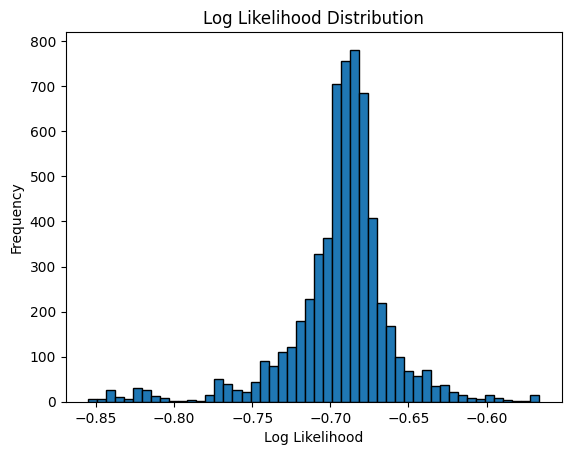

              Close  Predicted  Log_Likelihood Action
Date                                                 
2000-01-03  1455.22        NaN             NaN   Hold
2000-01-04  1399.42        0.0       -0.702043   Hold
2000-01-05  1402.11        0.0       -0.703493   Hold
2000-01-06  1403.45        0.0       -0.703892   Hold
2000-01-07  1441.47        0.0       -0.701362   Hold
...             ...        ...             ...    ...
2023-11-30  4567.80        1.0       -0.685186   Hold
2023-12-01  4594.63        1.0       -0.683636   Hold
2023-12-04  4569.78        1.0       -0.680935   Hold
2023-12-05  4567.18        1.0       -0.677977   Hold
2023-12-06  4549.34        1.0       -0.674754   Hold

[6021 rows x 4 columns]
Hold    4885
Sell     629
Buy      507
Name: Action, dtype: int64


In [294]:
# Make predictions on the entire dataset
predicted_values = model.predict(X_selected)

# Calculate log likelihood
log_likelihood = model.predict_log_proba(X_selected)[:, 1]

# Create a new DataFrame with the predicted values and set the index to match the original DataFrame
predicted_df = pd.DataFrame(index=X.index, data={'Predicted': predicted_values, 'Log_Likelihood': log_likelihood})

# Merge the predicted DataFrame with the original DataFrame
df = pd.concat([df, predicted_df], axis=1)

plt.hist(df['Log_Likelihood'], bins=50, edgecolor='black')
plt.title('Log Likelihood Distribution')
plt.xlabel('Log Likelihood')
plt.ylabel('Frequency')
plt.show()

mean_ll = df['Log_Likelihood'].mean()
std_ll = df['Log_Likelihood'].std()

# Choose a threshold based on a certain number of standard deviations from the mean
buy_threshold = mean_ll + std_ll
sell_threshold = mean_ll - std_ll

# Determine actions based on log likelihood values
df['Action'] = np.where(df['Log_Likelihood'] > buy_threshold, 'Buy', np.where(df['Log_Likelihood'] < sell_threshold, 'Sell', 'Hold'))

# Print the DataFrame with trading signals and actions
print(df[['Close', 'Predicted', 'Log_Likelihood', 'Action']])

action_counts = df['Action'].value_counts()
print(action_counts)

#Algorithm 2 (Change in Prediction)

In [295]:
# Make predictions on the entire dataset
predicted_values = model.predict(X_selected)

# Create a new DataFrame with the predicted values and set the index to match the original DataFrame
predicted_df = pd.DataFrame(index=X.index, data={'Non-Log-Predicted': predicted_values})

# Merge the predicted DataFrame with the original DataFrame
df = pd.concat([df, predicted_df], axis=1)

# Define trading signals based on predictions
df['Buy_Signal'] = np.where((df['Non-Log-Predicted'] == 1) & (df['Non-Log-Predicted'].shift(1) == 0), 1, 0)
df['Sell_Signal'] = np.where((df['Non-Log-Predicted'] == 0) & (df['Non-Log-Predicted'].shift(1) == 1), -1, 0)

#print("Buy Signals:", df['Buy_Signal'].sum())
#print("Sell Signals:", df['Sell_Signal'].sum())

# Combine buy and sell signals into a single column
df['Signal'] = df['Buy_Signal'] + df['Sell_Signal']

# Define trading actions (Buy, Hold, Sell)
df['Non-Log-Based-Action'] = np.where(df['Signal'] == 1, 'Buy', np.where(df['Signal'] == -1, 'Sell', 'Hold'))

# Print the DataFrame with trading signals and actions
print(df[['Close', 'Non-Log-Predicted', 'Buy_Signal', 'Sell_Signal', 'Signal', 'Non-Log-Based-Action']])

action_counts = df['Non-Log-Based-Action'].value_counts()
print(action_counts)

              Close  Non-Log-Predicted  Buy_Signal  Sell_Signal  Signal  \
Date                                                                      
2000-01-03  1455.22                NaN           0            0       0   
2000-01-04  1399.42                0.0           0            0       0   
2000-01-05  1402.11                0.0           0            0       0   
2000-01-06  1403.45                0.0           0            0       0   
2000-01-07  1441.47                0.0           0            0       0   
...             ...                ...         ...          ...     ...   
2023-11-30  4567.80                1.0           0            0       0   
2023-12-01  4594.63                1.0           0            0       0   
2023-12-04  4569.78                1.0           0            0       0   
2023-12-05  4567.18                1.0           0            0       0   
2023-12-06  4549.34                1.0           0            0       0   

           Non-Log-Based